# Analysing statistical workspaces with xRooFit

This notebook demonstrates some of the ways you can interact with ATLAS published workspaces. 

The supporting material for this new functionality is still being developed, therefore if you have any questions or comments about how you want to utilize the workspaces in your research, please contact the specially-prepared contact address: atlas-outreach-public-likelihoods@cern.ch 

# 0. Software setup

[xRooFit](https://root.cern.ch/doc/master/group__xroofit.html) is an API for RooFit statistical workspaces that is bundled with ROOT as of version 6.30. However, xRooFit is still under regular development, and the features used in this notebook will not be available until ROOT 6.32 is released (due May 2024). Until then, you can [checkout and compile the latest xRooFit](https://gitlab.cern.ch/will/xroofit) on top of ROOT if necessary. You can also setup the ROOT nightly build (although this may be unstable) through conda:
```
conda create -n root-nightly -c https://root.cern/download/conda-nightly/latest -c conda-forge root-nightly
conda activate root-nightly
```

In [3]:
import ROOT
from ROOT.Experimental import XRooFit as XRF # Will use ROOT's built-in version of xRooFit
#import ROOT as XRF # use this line if you have built xRooFit on top of ROOT and want to use that version
print("ROOT Version =",ROOT.gROOT.GetVersion(),",ROOT Date =",ROOT.gROOT.GetGitDate())
print("xRooFit Version =",XRF.xRooFit.GetVersion(),",xRooFit Date =",XRF.xRooFit.GetVersionDate())

ROOT Version = 6.33/01 ,ROOT Date = May 10 2024, 10:56:22
xRooFit Version = da7c74f ,xRooFit Date = 2024-05-08 14:51:33 +0200


# 1. Exploring workspaces

This notebook covers how to open a workspace and explore its content using the xRooFit API. All workspace exploration involve using the [xRooNode](https://root.cern.ch/doc/master/classROOT_1_1Experimental_1_1XRooFit_1_1xRooNode.html) class, which provides a high-level API for interacting with RooFit/HS3 workspaces.

## 1.1. Opening a workspace and listing its content

Start by creating an `xRooNode` from the file:

In [4]:
w = XRF.xRooNode("Unfolding_dPhi_ttbar_Z_5bins_comb_particle_tau2.4_NORM.json")

xRooFit -- Create/Explore/Modify Workspaces -- Development ongoing 
                xRooFit : http://gitlab.cern.ch/will/xroofit
                Version: da7c74f [2024-05-08 14:51:33 +0200]


Warning in <ROOT::Experimental::XRooFit::xRooNode::xRooNode>: Inferring initial errors of 116 parameters (TotalXsecOverTheory_dPhi_ttbar_Z,...) (give all nuisance parameters an error to avoid this msg)


You can explore the content of the workspace somewhat like you would a file system: each node contains sub-nodes, which you can interact with to explore ever deeper. Here are some examples to print out some basic information about the workspace (see https://xroofit.readthedocs.io/en/latest/basics.html for more documentation about the terminology):

In [5]:
print("This workspace contains",w["pdfs"].size(),"pdfs (", 
      [m.GetName() for m in w["pdfs"]], ") and",w["datasets"].size(),"datasets (",
      [d.GetName() for d in w["datasets"]],")")
print("There are", w.pars().size(), "parameters and",w.obs().size(),"observables (of which", 
      w.globs().size(),"are global and",w.robs().size(),"are regular)")
print(f"There are currently {w.floats().size()} floating parameters")
print(f"There are {w.poi().size()} parameters of interest:")
w.poi().Print()

This workspace contains 2 pdfs ( ['regularization_dPhi_ttbar_Z', 'simPdf'] ) and 2 datasets ( ['asimovData', 'obsData'] )
There are 470 parameters and 360 observables (of which 350 are global and 10 are regular)
There are currently 357 floating parameters
There are 4 parameters of interest:
Unfolding_dPhi_ttbar_Z_5bins_comb_particle_tau2.4_NORM.json/.poi: RooArgList::Unfolding_dPhi_ttbar_Z_5bins_comb_particle_tau2.4_NORM.json.poi
0) dPhi_ttbar_Z_Bin_001_mu : RooRealVar::dPhi_ttbar_Z_Bin_001_mu = 1  L(0 - 2) 
1) dPhi_ttbar_Z_Bin_002_mu : RooRealVar::dPhi_ttbar_Z_Bin_002_mu = 1  L(0 - 2) 
2) dPhi_ttbar_Z_Bin_003_mu : RooRealVar::dPhi_ttbar_Z_Bin_003_mu = 1  L(0 - 2) 
3) dPhi_ttbar_Z_Bin_004_mu : RooRealVar::dPhi_ttbar_Z_Bin_004_mu = 1  L(0 - 2) 


Note that subnodes can be accessed either by name or index. 

## 1.2. Accessing bin contents and uncertainties

Let us now explore the contents and uncertainties of a pdf in the workspace:

In [6]:
for chan in w["pdfs"]["simPdf"].bins(): # the 'bins' method will return the channels of a pdf if it is a multi-channel pdf (which simPdf is)
    print(chan.GetName(),": rob=",chan.robs()[0].GetName(), " , n_globs=", chan.globs().size()) #number of globs typically indicates number of systematics
    for i,bin in enumerate(chan.bins()):
        print("  bin",i,": content=",bin.GetContent(),"+/-",bin.GetError()," obsData=",bin.GetData("obsData"))
        if i==0: # we print the 'samples' (components) of just the first bin, to save on overprinting
            for samp in chan["samples"].components():
                print("    ",samp.GetName(),":",samp.bins()[0].GetContent(),"+/-",samp.bins()[0].GetError())

channelCat=reg_3l_ttZ : rob= obs_x_reg_3l_ttZ  , n_globs= 190
  bin 0 : content= 91.72166184275326 +/- 6.464007798506465  obsData= 108.0
     model_reg_3l_ttZ_WZb_shapes : 3.518642692078117 +/- 0.8948561987541364
     model_reg_3l_ttZ_WZc_shapes : 1.4433443114935471 +/- 0.5940116316365228
     model_reg_3l_ttZ_WZl_shapes : 0.17640714546723757 +/- 0.07719884069073976
     model_reg_3l_ttZ_ZZb_shapes : 0.7012360206313558 +/- 0.2231013369628657
     model_reg_3l_ttZ_ZZc_shapes : 0.1602072726636834 +/- 0.05113129352746797
     model_reg_3l_ttZ_ZZl_shapes : 0.0596180630109302 +/- 0.018568687410200235
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_1_shapes : 44.84818846861233 +/- 2.654479100071728
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_2_shapes : 9.55862408007654 +/- 0.7919084217030636
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_3_shapes : 5.648198393767563 +/- 0.5803313221516241
     model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_4_shapes : 3.148044

## 1.3. Visualizing the workspace

The whole model can also be visualized using the following code. Each panel of the plot shows the number of events in one channel (usually an analysis region, like a control region or a signal region) in the workspace. Some have several bins (like those in the top row), and some only have a single bin (two of the channels in the bottom row). In each panel the components of the background are drawn in different colors; a single background might enter in one or more channels. A statistical uncertainty is shown on the observed data to guide the eye; the systematic and any mc-statistical uncertainties, all captured as parameters in the workspace, are shown as a hatched band on the total background prediction.

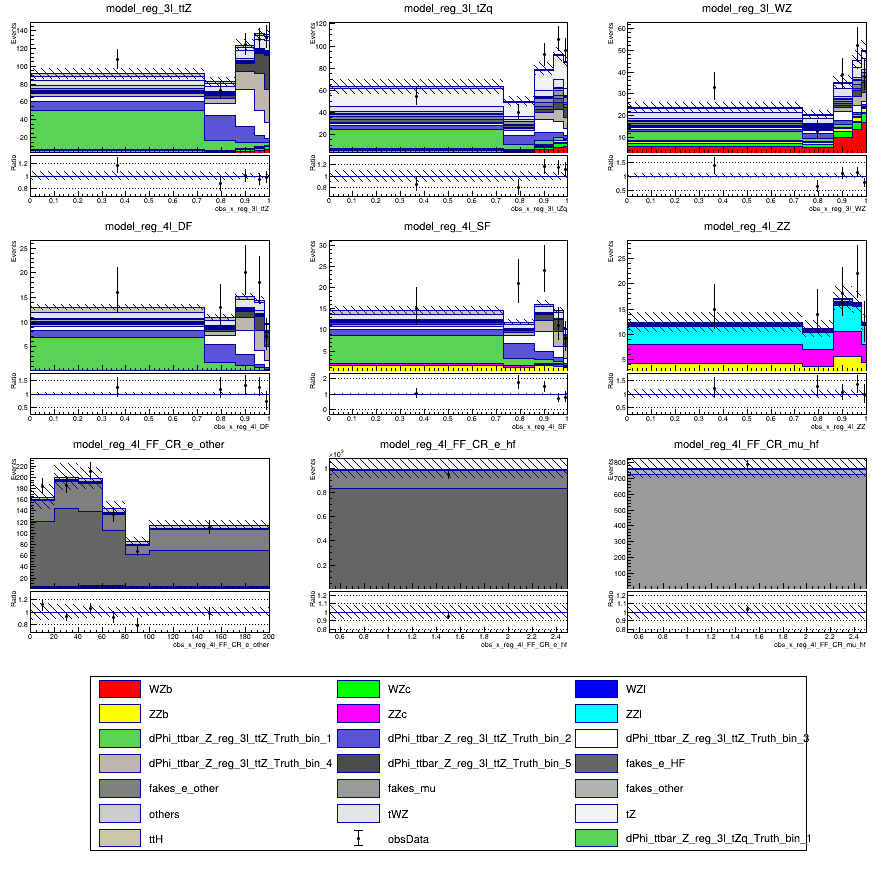

In [7]:
w["datasets/obsData"].SetChecked();w["datasets/asimovData"].SetChecked(False) # selects which datasets to display with the pdf            
ROOT.gStyle.SetOptStat(False) # turn off the stats-box that ROOT will display by default on every plot
c = ROOT.TCanvas("canv","canv",900,900)
ROOT.gStyle.SetLegendFont(43);ROOT.gStyle.SetLegendTextSize(12);
w["pdfs/simPdf"].Draw("eratio") # draw model with error bars and ratio plot
c.Draw()

A single plot showing the yield per channel is also possible, by specifying the channel categorical observable (`channelCat`) as the x-axis variable to draw. This plot shows the integrals in each of the channels as single bins of a single plot.

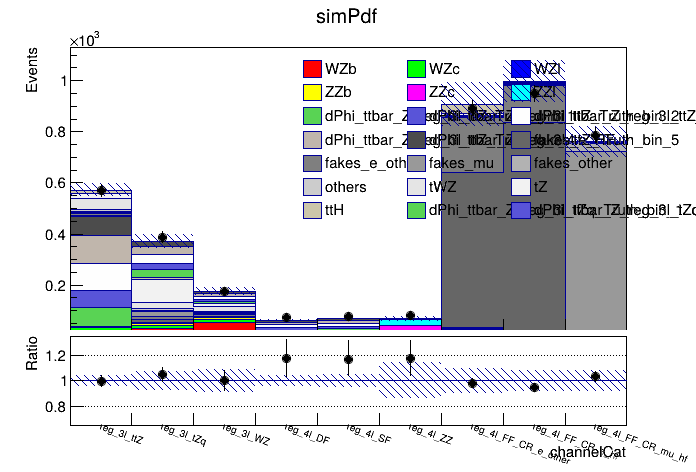

In [8]:
c = ROOT.TCanvas()
w["pdfs/simPdf"].Draw("eratio;x=channelCat")
c.Draw()

# 2. Modifying workspaces

Workspaces can be modified 'in-situ' or a new workspace can be created and objects added to it. We will see an example of both of these now ...

## 2.1. Modifying in-situ: Reparameterizing a parameter

We can use the `xRooNode::Replace` method to replace any variable with a generic function. The function must follow RooFit's [WS-factory language](https://root.cern.ch/doc/master/classRooFactoryWSTool.html#a228d9cb336a3bdc7dfe260f4c6aaf8df). For example:

In [9]:
poiName = w.poi()[0].GetName() # get the name of the first POI
w.poi()[0].Replace(f"expr::myFunc('2*{poiName}',{poiName})") # example of replacing the parameter everywhere in the workspace with a function that multiplies it by 2

# we can save this modified workspace like this:
w.SaveAs("reparameterized_ws.root")

# restore the state of the workspace by replacing the function again with the original poi
# Can get a list of all functions in a workspace using the `factors()` method on the workspace:
w.factors()["myFunc"].Replace(poiName) #if you were to now Print the workspace, `myFunc` will appear in the 'scratch' folder, because it isn't part of a pdf any more

xRooNode{}

Warning in <ROOT::Experimental::XRooFit::xRooNode::Replace>: Replacing dPhi_ttbar_Z_Bin_001_mu in all clients: mu_prime_2,dPhi_ttbar_Z_Bin_005_mu,model_reg_3l_WZ_dPhi_ttbar_Z_reg_3l_WZ_Truth_bin_1_scaleFactors,model_reg_3l_tZq_dPhi_ttbar_Z_reg_3l_tZq_Truth_bin_1_scaleFactors,model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_1_scaleFactors,model_reg_4l_DF_dPhi_ttbar_Z_reg_4l_DF_Truth_bin_1_scaleFactors,model_reg_4l_SF_dPhi_ttbar_Z_reg_4l_SF_Truth_bin_1_scaleFactors,model_reg_4l_ZZ_dPhi_ttbar_Z_reg_4l_ZZ_Truth_bin_1_scaleFactors,
Info in <ROOT::Experimental::XRooFit::xRooNode::SaveAs>: workspace saved to reparameterized_ws.root
Warning in <ROOT::Experimental::XRooFit::xRooNode::Replace>: Replacing myFunc in all clients: mu_prime_2,dPhi_ttbar_Z_Bin_005_mu,model_reg_3l_WZ_dPhi_ttbar_Z_reg_3l_WZ_Truth_bin_1_scaleFactors,model_reg_3l_tZq_dPhi_ttbar_Z_reg_3l_tZq_Truth_bin_1_scaleFactors,model_reg_3l_ttZ_dPhi_ttbar_Z_reg_3l_ttZ_Truth_bin_1_scaleFactors,model_reg_4l_DF_dPhi_ttbar_Z_reg_4l_DF_T

## 2.2. Creating a new workspace: Selecting a subset of the channels

We can use the `xRooNode::reduced` method to create a shallow-copy of a multi-channel pdf for a subset of the channels. This new pdf is not added to the workspace (but it can be), but we will show how we can instead add it to a new workspace, along with the obsData associated to the selected channels:

In [10]:
newModel = w["pdfs/simPdf"].reduced("reg_3l_ttZ,reg_4l_*") # specify subset of channels as comma separated list, note you can use wildcards.
print("There are",newModel.bins().size(),"channels in reduced model")

# we can save this reduced pdf to a workspace of its own, if we wish ....
w2 = XRF.xRooNode("RooWorkspace","newws","my new workspace") # Creates a new RooWorkspace (name=newws,title=my new workspace), wrapped by an xRooNode
w2.Add(newModel) # note: workspaces create an owned copy of things that get added to them
w2.Add(newModel.datasets()["obsData"]) # also add the subset of the obsData dataset that is relevant to newModel
w2.Print() # inspect the content of this workspace before saving
w2.SaveAs("reduced_ws.root") # BUG: json serializer currently crashing, so can only save as a ROOT file at the moment

There are 7 channels in reduced model
[#1] INFO:ObjectHandling -- RooWorkspace::import(newws) importing dataset obsData
newws: RooWorkspace::newws
!pdfs
 0) simPdf_reduced : RooSimultaneous::simPdf_reduced
!datasets
 1) obsData : RooDataSet::obsData[channelCat,obs_x_reg_3l_ttZ,obs_x_reg_4l_DF,obs_x_reg_4l_FF_CR_e_hf,obs_x_reg_4l_FF_CR_e_other,obs_x_reg_4l_FF_CR_mu_hf,obs_x_reg_4l_SF,obs_x_reg_4l_ZZ,weight:weight] = 28 entries (3430 weighted)


Info in <ROOT::Experimental::XRooFit::xRooNode::SaveAs>: newws saved to reduced_ws.root


# 3. Constructing NLL Functions

An NLL function (the objective function to be minimized) is constructed from a pdf and a dataset using the `xRooNode::nll` method. 

## 3.1. Choose which parameters to float

While this isn't strictly necessary to do before constructing the NLL function, there are certain **constant term optimizations** that can be performed if you first mark constant any parameter you plan to hold constant during any fit(s), which can allow the fit to run faster by optimizing the evaluation of the NLL function. Also, the fewer parameters that are floating, the faster the fit will run. 

For this example we will only float the poi and a subset of the nuisance parameters ([see here](https://xroofit.readthedocs.io/en/latest/basics.html#changing-parameters-from-floating-to-constant-and-vice-versa) for more information about the methods used):

In [11]:
w.pars().setAttribAll("Constant") # marks all parameters constant
w.poi().setAttribAll("Constant",False) # re-floats all the poi
w.pars().reduced("alpha_EG*,gamma_stat_reg_4l_SF*").setAttribAll("Constant",False) # re-floats some nuisance parameters (usually represent systematics)
print("There are",w.floats().size(),"floating parameters")

There are 12 floating parameters


## 3.2. Select NLL Options

There are a number of NLL-construction options available, [listed here](https://root.cern.ch/doc/master/classRooAbsPdf.html#a24b1afec4fd149e08967eac4285800de). The NLL options can be assembled as follows:

In [12]:
nllOpts = XRF.xRooFit.createNLLOptions() # use the default xRooFit options as a starting point (enables offsetting, and disables const-term optimization)
nllOpts.Add(ROOT.RooFit.ExternalConstraints(w.pdf("regularization_dPhi_ttbar_Z")).Clone()) # add second pdf as the regularization term for the NLL
nllOpts.Add(ROOT.RooFit.EvalBackend("legacy").Clone()) # use legacy backend evaluation method

## 3.3. Constructing the NLL with a pdf, dataset, and NLL Options list

Now you can create the NLL function for your chosen pdf. If you pass "" as the dataset name an asimov dataset corresponding to the current state of the model will be used. 

In [13]:
nll = w["pdfs/simPdf"].nll("obsData",nllOpts)
nll.Print() # Prints the PDF, Dataset, NLL Options, and Fit Config

PDF: RooSimultaneous::simPdf[ indexCat=channelCat reg_3l_WZ=model_reg_3l_WZ reg_3l_tZq=model_reg_3l_tZq reg_3l_ttZ=model_reg_3l_ttZ reg_4l_DF=model_reg_4l_DF reg_4l_FF_CR_e_hf=model_reg_4l_FF_CR_e_hf reg_4l_FF_CR_e_other=model_reg_4l_FF_CR_e_other reg_4l_FF_CR_mu_hf=model_reg_4l_FF_CR_mu_hf reg_4l_SF=model_reg_4l_SF reg_4l_ZZ=model_reg_4l_ZZ ] = 0.119548
Data: RooDataSet::obsData[channelCat,obs_x_reg_3l_WZ,obs_x_reg_3l_tZq,obs_x_reg_3l_ttZ,obs_x_reg_4l_DF,obs_x_reg_4l_FF_CR_e_hf,obs_x_reg_4l_FF_CR_e_other,obs_x_reg_4l_FF_CR_mu_hf,obs_x_reg_4l_SF,obs_x_reg_4l_ZZ,weight:weight] = 38 entries (3993 weighted)
NLL Options: 
 GlobalObservablesSource : model
 OffsetLikelihood : 1
 Optimize : 0
 ExternalConstraints : regularization_dPhi_ttbar_Z
 EvalBackend : 0
 GlobalObservables : nom_alpha_BTag_B_0,nom_alpha_BTag_B_1,nom_alpha_BTag_B_10,nom_alpha_BTag_B_11,nom_alpha_BTag_B_12,nom_alpha_BTag_B_13,nom_alpha_BTag_B_14,nom_alpha_BTag_B_15,nom_alpha_BTag_B_16,nom_alpha_BTag_B_17,nom_alpha_BTag_B_1

## 3.4. Evaluating the NLL function

The NLL function can be evaluated while varying some of the parameters of the model:

In [14]:
poi = w.poi()[0]
startVal = poi.getVal()
for val in [ poi.getMin()+x/10.*(poi.getMax()-poi.getMin()) for x in range(11) ]: # scan from min to max allowed value
    poi.setVal(val)
    print(poi.GetName(),"=",val," nll=",nll.getVal())
poi.setVal(startVal) # reset value

dPhi_ttbar_Z_Bin_001_mu = 0.0  nll= 9511.889887190646
dPhi_ttbar_Z_Bin_001_mu = 0.2  nll= 9493.677364438594
dPhi_ttbar_Z_Bin_001_mu = 0.4  nll= 9480.07046962861
dPhi_ttbar_Z_Bin_001_mu = 0.6  nll= 9470.321105836969
dPhi_ttbar_Z_Bin_001_mu = 0.8  nll= 9463.945091332023
dPhi_ttbar_Z_Bin_001_mu = 1.0  nll= 9460.624101488296
dPhi_ttbar_Z_Bin_001_mu = 1.2  nll= 9460.152870884496
dPhi_ttbar_Z_Bin_001_mu = 1.4  nll= 9462.409826702522
dPhi_ttbar_Z_Bin_001_mu = 1.6  nll= 9467.341227343988
dPhi_ttbar_Z_Bin_001_mu = 1.8  nll= 9474.954184978653
dPhi_ttbar_Z_Bin_001_mu = 2.0  nll= 9485.316708851196
[#1] INFO:Minimization -- RooNLLVar::evaluatePartition(reg_3l_WZ) first = 0 last = 5 Likelihood offset now set to 405.768
[#1] INFO:Minimization -- RooNLLVar::evaluatePartition(reg_3l_tZq) first = 0 last = 5 Likelihood offset now set to 870.406
[#1] INFO:Minimization -- RooNLLVar::evaluatePartition(reg_3l_ttZ) first = 0 last = 5 Likelihood offset now set to 1302.29
[#1] INFO:Minimization -- RooNLLVar::ev

# 4. NLL Minimization

## 4.1. Running an inidividual minimization

Before running the first minimization with the NLL, the **fit config** should be set as required using both the `nll.fitConfig().MinimizerOptions()` and `nll.fitConfigOptions().SetValue("optName",...)` methods (the latter is used for the 'specific' options). For example, to strange the minimization strategy starting value, you can do: `nll.fitConfig().MinimizerOptions().SetStrategy(...)`. To change the Hesse strategy you can do `nll.fitConfigOptions().SetValue("HesseStrategy",...)`


In [15]:
fr = nll.minimize()
print("Fit status (0=good):",fr.status(),", Covariance Quality (3=good):",fr.covQual())
assert(fr.status()==0)
assert(fr.covQual()==3) # just to check results are good

for p in fr.floatParsFinal():
    print(p.GetName(),"=",p.getVal(),"+/-",p.getError())

Fit status (0=good): 0 , Covariance Quality (3=good): 3
alpha_EG_RESOLUTION_ALL = -0.029312115905352928 +/- 0.9923143859332498
alpha_EG_SCALE_AF2 = -0.0009519399650241137 +/- 0.9933478338128263
alpha_EG_SCALE_ALL = -0.36719110948036393 +/- 0.9105204443139703
dPhi_ttbar_Z_Bin_001_mu = 1.107660255162599 +/- 0.1525339990062326
dPhi_ttbar_Z_Bin_002_mu = 1.023806140479727 +/- 0.14998224517790293
dPhi_ttbar_Z_Bin_003_mu = 1.0667853073687743 +/- 0.15156569541211923
dPhi_ttbar_Z_Bin_004_mu = 0.9742966335054583 +/- 0.13316231340106
gamma_stat_reg_4l_SF_bin_0 = 0.999939693668093 +/- 0.020891660475854557
gamma_stat_reg_4l_SF_bin_1 = 1.0017822343118143 +/- 0.025861418559982474
gamma_stat_reg_4l_SF_bin_2 = 1.0009588864171526 +/- 0.020604317995243593
gamma_stat_reg_4l_SF_bin_3 = 0.9995303336144047 +/- 0.02205958143027381
gamma_stat_reg_4l_SF_bin_4 = 0.9995817635963554 +/- 0.028156016502113745


## 4.2. Post-fit model visualization

After the minimization, the model parameters and uncertainties have become set to the post-fit values. However, the correlations between the parameters is not yet set in the workspace. This must be done explicitly before obtaining any model yield errors. Note that all parameters that were held constant in the fit will no longer contribute to the uncertainties in the model (even if they have an error value). 

This is done using `xRooNode::SetFitResult`:

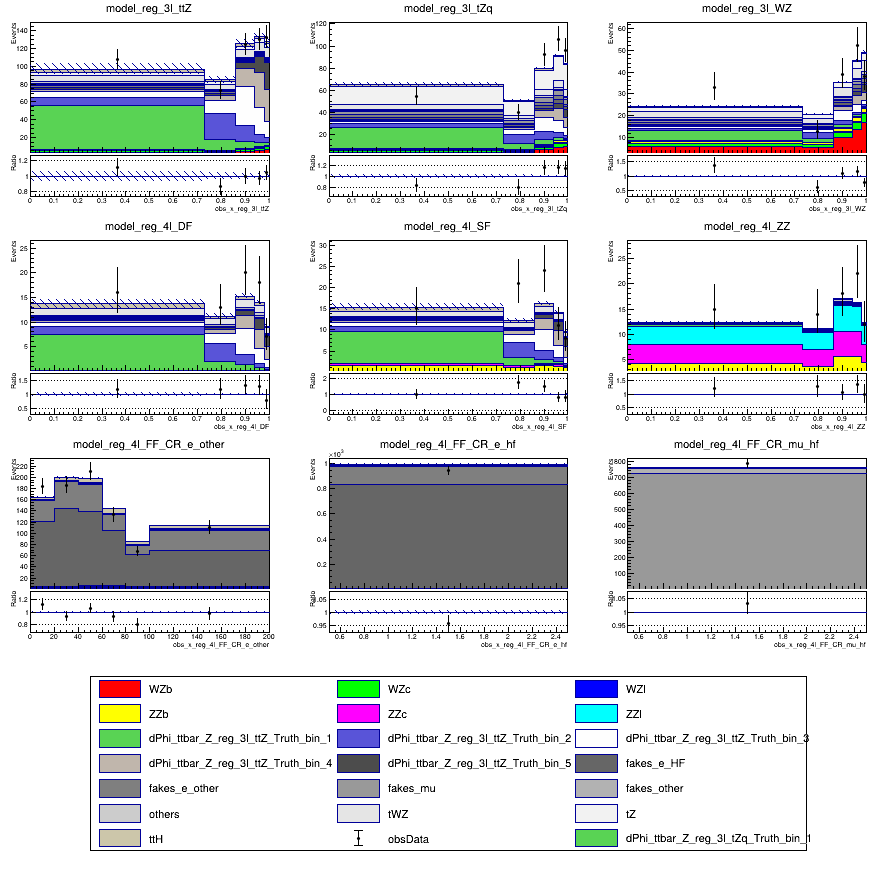

In [16]:
w.SetFitResult(fr) # ensures post-fit parameter values, uncertainties, and correlations are available to the model when calculating yields and errors
# now redraw model
c = ROOT.TCanvas("canv","canv",900,900)
w["pdfs/simPdf"].Draw("eratio")
c.Draw()

## 4.3. Calculating Impact

Impact is a way to describe the correlation between two parameters. It can be estimated using the correlation matrix, but the full calculation involves running the fit with the second parameter moved to its +/- 1 sigma values (using if prefit or postfit uncertainties) and evaluating the change in the best-fit value of the first parameter. Here's how to get the approx values (change `approx` to `False` to do the full calculation):

In [17]:
poiName = w.poi()[0].GetName()
npName = w.np().floats()[0].GetName()
print(f"Hessian post-fit impact of {npName} on {poiName}:",
      fr.impact(poiName,npName,up=True,prefit=False,approx=True),
      fr.impact(poiName,npName,up=False,prefit=False,approx=True) ) # change prefit to True for pre-fit impact

Hessian post-fit impact of alpha_EG_RESOLUTION_ALL on dPhi_ttbar_Z_Bin_001_mu: -0.00018684585225552173 0.00018684585225552173


All the approximated impacts can be visualized in an impact plot:

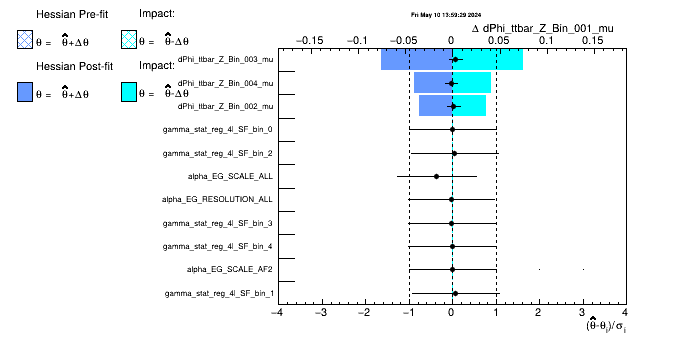

In [18]:
c = ROOT.TCanvas("impact","impact",700,160+20*(fr.floatParsFinal().size()-1)) # ensures height of canvas enough for params
fr.Draw(f"impact:{poiName}") # draw 'hessian' impact plot for poi
c.Draw()

## 4.4. Calculating Conditional Uncertainties

The conditional uncertainty on a parameter is the uncertainty that parameter has if the parameters it is conditioned on were held constant. The difference (in quadrature) to the total uncertainty is often quoted as the component of the total uncertainty due to the conditioned parameters. If we condition on all the parameters we obtain the stat-only uncertainty.

In [19]:
for poi in w.poi():
    totErr = fr.floatParsFinal().find(poi.GetName()).getError()
    statErr = fr.conditionalError(poi.GetName(),"*",up=True,approx=True)
    systErr = ROOT.TMath.Sqrt(ROOT.TMath.Power(totErr,2) - ROOT.TMath.Power(statErr,2))
    print(poi.GetName(),":",poi.getVal(),"+/-",statErr,"(stat) +/-",systErr,"(syst)")

dPhi_ttbar_Z_Bin_001_mu : 1.107660255162599 +/- 0.11968462509449251 (stat) +/- 0.09456326648770198 (syst)
dPhi_ttbar_Z_Bin_002_mu : 1.023806140479727 +/- 0.1281946194414425 (stat) +/- 0.07785122616162393 (syst)
dPhi_ttbar_Z_Bin_003_mu : 1.0667853073687743 +/- 0.13136478926281833 (stat) +/- 0.07560060957224239 (syst)
dPhi_ttbar_Z_Bin_004_mu : 0.9742966335054583 +/- 0.11173341331354845 (stat) +/- 0.07244201860540522 (syst)


## 4.5. Running a profile likelihood scan

A series of conditional fits are required for a profile likelihood scan. This can be accomplished using an `xRooHypoSpace` which is an object designed for hypothesis testing, where profile likelihood test-statistics are commonly used:

In [20]:
poiName = w.poi()[0].GetName()
mu_hat = fr.floatParsFinal().find(poiName) # the best-fit value ... will use to define the range of the scan
hs = nll.hypoSpace(poiName) # create a 1d hypothesis space with the given parameter
hs.scan("plr",11,mu_hat.getVal() - mu_hat.getError()*3, mu_hat.getVal() + mu_hat.getError()*3) # scan 11 points
for hp in hs:
    print(poiName,"=",hp.fNullVal(),", plr = ",hp.ts_asymp().first,"+/-",hp.ts_asymp().second) #ts stands for test-statistic
    # if the conditional fit failed, the ts value will be a nan ... can look get some more info about status code of fit from printing hypoPoint
    if ROOT.TMath.IsNaN(hp.ts_asymp().first): hp.Print()

dPhi_ttbar_Z_Bin_001_mu = 0.650058 , plr =  9.617622949233919 +/- 2.2334246915660122e-07
dPhi_ttbar_Z_Bin_001_mu = 0.741579 , plr =  6.05598454930805 +/- 2.0461703879331946e-07
dPhi_ttbar_Z_Bin_001_mu = 0.833099 , plr =  3.354211326321092 +/- 2.0459278780793825e-07
dPhi_ttbar_Z_Bin_001_mu = 0.924619 , plr =  1.4689852969386266 +/- 2.045783334983481e-07
dPhi_ttbar_Z_Bin_001_mu = 1.01614 , plr =  0.3621489075922 +/- 5.449124335104471e-06
dPhi_ttbar_Z_Bin_001_mu = 1.10766 , plr =  -1.983389665838331e-07 +/- 2.0463480299522364e-07
dPhi_ttbar_Z_Bin_001_mu = 1.19918 , plr =  0.3527115714059619 +/- 3.219461489531747e-06
dPhi_ttbar_Z_Bin_001_mu = 1.2907 , plr =  1.3938516380912915 +/- 7.378412546877557e-06
dPhi_ttbar_Z_Bin_001_mu = 1.38222 , plr =  3.0999902671355812 +/- 4.694782780814805e-06
dPhi_ttbar_Z_Bin_001_mu = 1.47374 , plr =  5.450384516094346 +/- 1.2088178800358647e-05
dPhi_ttbar_Z_Bin_001_mu = 1.56526 , plr =  8.426639402601722 +/- 2.260131102935318e-05
[#1] INFO:Eval -- RooRealVar:

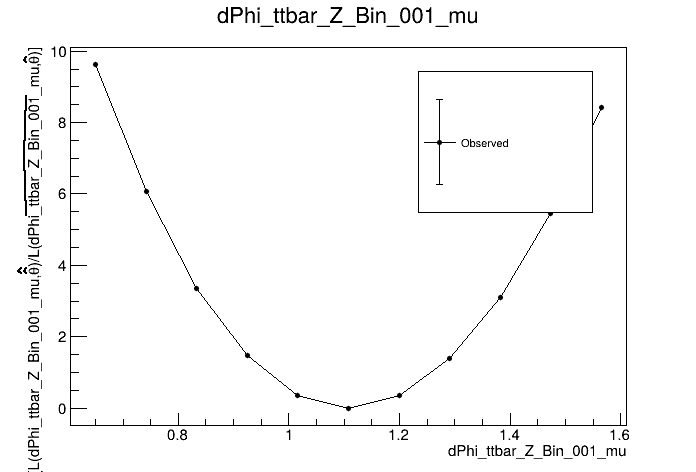

In [21]:
# can also just plot the hypoSpace:
c = ROOT.TCanvas()
hs.Draw()
c.Draw()